# Projeto 2 - Ciência dos Dados 

### Participantes:

- Bernardo Cunha Capoferri

- Francisco Pinheiro Janela

- Henrique Martinelli Frezzatti

- Lívia Sayuri Makuta



## Objetivo:

No Projeto 2 a equipe escolheu analisar músicas que estão ou foram do Top 100 da Billboard e classificá-las no gênero RAP (target), por meio de características atribuidas à música analisada (features). Para isso vamos usar alguns classificadores de modelos diferentes, como a  `Decision Tree` ('Árvore de decisão'), `Random Forest`('Árvores aleatórias') e `Logistic Regression` ('Regressão Logística') e responder a seguinte pergunta: 'Qual dos classificadores demonstrou melhor performance na classifcação?'. E, para alcançar nosso objetivo, primeiro iremos treinar nossos classificadores com uma base de dados de treinamento que possui músicas e suas características e que já foram da Top 100 semanal da Billboard, e por fim, utilizar esses classificadores já treinados na base de dados de teste, para saber de fato o desempenho desses classificadores. Lembrando que o `DataSet` escolhido provém da plataforma de músicas `Spotify`.

Carregando algumas bibliotecas que serão usadas no Projeto:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix

Para começar a análise, vamos carregar o DataSet escolhido:

In [2]:
filename = 'Hot_100_Audio_Features_completo.xlsx'
if filename in os.listdir():
    print("DataSet ok!")
else:
    print("Problema no Loading...")
    
DataFrame = pd.read_excel(filename)
DataFrame.head()

DataSet ok!


,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_album,spotify_track_explicit,spotify_track_duration_ms,spotify_track_popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,"AdictoTainy, Anuel AA & Ozuna","Tainy, Anuel AA & Ozuna",Adicto,['pop reggaeton'],3jbT1Y5MoPwEIpZndDDwVq,NaN,Adicto (with Anuel AA & Ozuna),0.0,270740.0,91.0,...,10.0,-4.803,0.0,0.0735,0.01700,0.000016,0.1790,0.623,80.002,4.0
1,The Ones That Didn't Make It Back HomeJustin M...,Justin Moore,The Ones That Didn't Make It Back Home,"['arkansas country', 'contemporary country', '...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ShallowLady Gaga & Bradley Cooper,Lady Gaga & Bradley Cooper,Shallow,"['dance pop', 'pop']",2VxeLyX666F8uXCJ0dZF8B,NaN,A Star Is Born Soundtrack,0.0,215733.0,88.0,...,7.0,-6.362,1.0,0.0308,0.37100,0.000000,0.2310,0.323,95.799,4.0
3,EnemiesPost Malone Featuring DaBaby,Post Malone Featuring DaBaby,Enemies,"['dfw rap', 'melodic rap', 'rap']",0Xek5rqai2jcOWCYWJfVCF,NaN,Hollywood's Bleeding,1.0,196760.0,86.0,...,6.0,-4.169,1.0,0.2100,0.05880,0.000000,0.0955,0.667,76.388,4.0
4,"Bacc At It AgainYella Beezy, Gucci Mane & Quavo","Yella Beezy, Gucci Mane & Quavo",Bacc At It Again,"['dfw rap', 'rap', 'southern hip hop', 'trap']",2biNa12dMbHJrHVFRt8JyO,https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...,Bacc At It Again,1.0,228185.0,61.0,...,8.0,-5.725,0.0,0.1680,0.00124,0.000001,0.0716,0.856,135.979,4.0


## 1) Limpeza e Manipulação dos dados:

### [1.1a] Limpeza:

Vamos começar tirando as colunas que não interferem na classificação e depois excluir as linhas que não possuem informação.

In [3]:
#=================================================== Colunas desejadas ========================================================
# escolhemos as colunas que importam para a classificação
DataFrame = DataFrame.loc[:,['spotify_genre','loudness','spotify_track_popularity','spotify_track_duration_ms',
                             'spotify_track_explicit','danceability','mode','speechiness','energy','instrumentalness',
                             'acousticness','liveness','valence']]

#==================================================== Excluindo linhas ========================================================
# a função exclui as linhas que possuem células sem informação (NaN)
DataFrame = DataFrame.dropna()

DataFrame.head()  #debug

,spotify_genre,loudness,spotify_track_popularity,spotify_track_duration_ms,spotify_track_explicit,danceability,mode,speechiness,energy,instrumentalness,acousticness,liveness,valence
0,['pop reggaeton'],-4.803,91.0,270740.0,0.0,0.734,0.0,0.0735,0.836,0.000016,0.01700,0.1790,0.623
2,"['dance pop', 'pop']",-6.362,88.0,215733.0,0.0,0.572,1.0,0.0308,0.385,0.000000,0.37100,0.2310,0.323
3,"['dfw rap', 'melodic rap', 'rap']",-4.169,86.0,196760.0,1.0,0.542,1.0,0.2100,0.674,0.000000,0.05880,0.0955,0.667
4,"['dfw rap', 'rap', 'southern hip hop', 'trap']",-5.725,61.0,228185.0,1.0,0.948,0.0,0.1680,0.623,0.000001,0.00124,0.0716,0.856
5,"['dance pop', 'pop', 'post-teen pop']",-9.375,76.0,211240.0,0.0,0.292,1.0,0.0401,0.574,0.005690,0.12000,0.0663,0.166


Com as colunas restantes, temos as seguintes variáveis e suas descrições:

* spotify_genre: gênero da música na plataforma 'Spotify'.
* loudness: o volume geral de uma faixa em decibéis (dB). Os valores típicos variam entre -60 e 0 dB. 
* spotify_track_popularity: a popularidade da faixa. Esse valor está entre 0 e 100, sendo 100 o mais popular.
* spotify_track_duration_ms: a duração da faixa musical em milisegundos.
* spotify_track_explicit: se a faixa tem ou não letras explícitas (verdadeiro = 1, tem; falso = 0, não OU desconhecido). 
* danceability: descreve o quanto uma faixa é adequada para dançar com base em uma combinação de elementos musicais. Um valor de 0.0 é menos dançante, e 1.0 é o mais dançante.
* mode: indica a modalidade ou o tipo de escala de uma faixa musical, sendo maior ou menor. Maior é representado por 1 e menor é 0.
* speechiness: detecta a presença de palavras faladas em uma faixa. Quanto mais exclusivamente falada for a gravação, mais próximo de 1.0 será seu valor. Valores acima de 0,66 descrevem faixas que provavelmente são compostas inteiramente de palavras faladas. Valores entre 0.33 e 0.66 descrevem faixas que podem conter música e fala, em seções ou em camadas, incluindo casos como música rap. Valores abaixo de 0.33 provavelmente representam música e outras faixas não semelhantes à fala.
* energy:  é uma medida que representa a intensidade e atividade de uma música, que varia entre 1.0 (uma faixa muito energética) e 0.0 (uma faixa não energética). Normalmente, as faixas energéticas parecem rápidas, altas e barulhentas. 
* instrumentalness: prevê se uma faixa não contém vocais. Quanto mais próximo o valor da instrumentalidade estiver de 1.0, maior será a probabilidade de a faixa não conter conteúdo vocal. Valores acima de 0.5 destinam-se a representar faixas instrumentais, sendo 1.0 seu valor máximo. 
* acousticness: uma medida de confiança de 0.0 a 1.0 para saber se a faixa é acústica. 1.0 representa alta confiança de que a faixa é acústica e 0.0 de que não é acústica.
* liveness: detecta a presença de um público na gravação. Valores de vivacidade mais altos representam um aumento na probabilidade de a trilha ter sido executada ao vivo. Um valor acima de 0.8 fornece uma grande probabilidade de que a faixa tenha sido gravada ao vivo.
* valence: uma medida de 0.0 a 1.0 que descreve a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórico), enquanto faixas com baixa valência soam mais negativas (por exemplo, triste, deprimido, irritado).



Para mais informações de como as classificações dessas caracteristícas foram feitas, visitar o site da plataforma musical Spotify.

### [1.1b] Criando uma nova série 'classificação':

Depois disso, como o objetivo é classificar o gênero de uma música como sendo rap ou não, é preciso filtrar a base de dados para fazer essa separação. Por isso, criamos uma nova coluna chamada 'classificação' que classifica as músicas como sendo "Rap" ou "Outro". 

In [4]:
#filtrando o DataFrame para classificar as informações pertencendo ao gênero 'rap' ou 'outro'.

DataFrame["classificacao"]= DataFrame["spotify_genre"].str.contains("rap")


DataFrame['classificacao'] = DataFrame['classificacao'].astype('category')
DataFrame['classificacao'].cat.categories = ['Outro','Rap']

DataFrame.head()

,spotify_genre,loudness,spotify_track_popularity,spotify_track_duration_ms,spotify_track_explicit,danceability,mode,speechiness,energy,instrumentalness,acousticness,liveness,valence,classificacao
0,['pop reggaeton'],-4.803,91.0,270740.0,0.0,0.734,0.0,0.0735,0.836,0.000016,0.01700,0.1790,0.623,Outro
2,"['dance pop', 'pop']",-6.362,88.0,215733.0,0.0,0.572,1.0,0.0308,0.385,0.000000,0.37100,0.2310,0.323,Outro
3,"['dfw rap', 'melodic rap', 'rap']",-4.169,86.0,196760.0,1.0,0.542,1.0,0.2100,0.674,0.000000,0.05880,0.0955,0.667,Rap
4,"['dfw rap', 'rap', 'southern hip hop', 'trap']",-5.725,61.0,228185.0,1.0,0.948,0.0,0.1680,0.623,0.000001,0.00124,0.0716,0.856,Rap
5,"['dance pop', 'pop', 'post-teen pop']",-9.375,76.0,211240.0,0.0,0.292,1.0,0.0401,0.574,0.005690,0.12000,0.0663,0.166,Outro


### [1.2] Categorizando:

Como a maioria de nossos features são numéricos, para que não haja confusão em um primeiro momento, iremos alterar os valores de '0.0' e '1.0' utilizados para classificar a explicitabilidade e a modalidade de escala musical. Sendo assim, as colunas `spotify_track_explicit` e `mode` que são categóricas, ao invés de serem expressas em números, serão expressas nominalmente com suas características. Logo, o 1.0 e 0.0 do `mode` serão expressos por 'Major'(escala maior) e 'Minor' (escala menor), respectivamente, enquanto esses mesmos números para o `spotify_track_explicit` representarão 'Explicit'(contém explicitabilidade e 'Free'(livre de explicitabilidade).

In [5]:
#===================================================== Categorizando ==========================================================
# Transformando a coluna em uma categoria
DataFrame['spotify_track_explicit'] = DataFrame['spotify_track_explicit'].astype('category')
DataFrame['mode'] = DataFrame['mode'].astype('category')

# Trocando os valores pelas categorias correspondentes:
DataFrame['spotify_track_explicit'].cat.categories = ['Free','Explicit']
DataFrame['mode'].cat.categories = ['Minor','Major']

DataFrame.head()  #debug

,spotify_genre,loudness,spotify_track_popularity,spotify_track_duration_ms,spotify_track_explicit,danceability,mode,speechiness,energy,instrumentalness,acousticness,liveness,valence,classificacao
0,['pop reggaeton'],-4.803,91.0,270740.0,Free,0.734,Minor,0.0735,0.836,0.000016,0.01700,0.1790,0.623,Outro
2,"['dance pop', 'pop']",-6.362,88.0,215733.0,Free,0.572,Major,0.0308,0.385,0.000000,0.37100,0.2310,0.323,Outro
3,"['dfw rap', 'melodic rap', 'rap']",-4.169,86.0,196760.0,Explicit,0.542,Major,0.2100,0.674,0.000000,0.05880,0.0955,0.667,Rap
4,"['dfw rap', 'rap', 'southern hip hop', 'trap']",-5.725,61.0,228185.0,Explicit,0.948,Minor,0.1680,0.623,0.000001,0.00124,0.0716,0.856,Rap
5,"['dance pop', 'pop', 'post-teen pop']",-9.375,76.0,211240.0,Free,0.292,Major,0.0401,0.574,0.005690,0.12000,0.0663,0.166,Outro


### [1.4] Separação dos dados do DataFrame:

Para realizar a análise exploratória inicial dos dados, separamo-nos em dois DataFrames de acordo com a sua classificação musical, isto é, se é 'rap' ou se pertence a outro gênero musical.

In [6]:
#Separando todos os dados das outras variáveis que pertencem ao gênero rap. 

filtro_rap = DataFrame['classificacao'] == 'Rap'
dados_rap = DataFrame.loc[filtro_rap,:]

dados_rap

,spotify_genre,loudness,spotify_track_popularity,spotify_track_duration_ms,spotify_track_explicit,danceability,mode,speechiness,energy,instrumentalness,acousticness,liveness,valence,classificacao
3,"['dfw rap', 'melodic rap', 'rap']",-4.169,86.0,196760.0,Explicit,0.542,Major,0.2100,0.674,0.000000,0.05880,0.0955,0.667,Rap
4,"['dfw rap', 'rap', 'southern hip hop', 'trap']",-5.725,61.0,228185.0,Explicit,0.948,Minor,0.1680,0.623,0.000001,0.00124,0.0716,0.856,Rap
6,"['nc hip hop', 'rap']",-2.708,88.0,144935.0,Explicit,0.768,Minor,0.3070,0.652,0.000000,0.11300,0.1070,0.777,Rap
7,"['hip hop', 'pop rap', 'rap']",-3.985,74.0,196800.0,Free,0.817,Major,0.1850,0.814,0.000000,0.32000,0.1520,0.247,Rap
8,"['dfw rap', 'melodic rap', 'rap']",-3.206,85.0,156266.0,Free,0.405,Minor,0.0476,0.646,0.000000,0.33100,0.1030,0.170,Rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28465,"['dfw rap', 'melodic rap', 'rap']",-5.198,74.0,204360.0,Explicit,0.742,Minor,0.0471,0.840,0.000000,0.14300,0.1330,0.287,Rap
28468,"['dance pop', 'pop', 'pop rap', 'r&b', 'rap']",-4.564,58.0,214600.0,Explicit,0.731,Minor,0.0638,0.818,0.000000,0.05170,0.0743,0.812,Rap
28469,"['florida rap', 'hip hop', 'melodic rap', 'mia...",-5.788,84.0,228759.0,Explicit,0.861,Minor,0.1760,0.603,0.000000,0.05210,0.0924,0.504,Rap
28475,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",-7.673,51.0,278429.0,Explicit,0.852,Major,0.4260,0.438,0.000000,0.01450,0.2630,0.627,Rap


In [7]:
#Separando todos os dados das outras variáveis que pertencem a outros gêneros. 

filtro_outro = DataFrame['classificacao'] == 'Outro'
dados_outro = DataFrame.loc[filtro_outro,:]

dados_outro

,spotify_genre,loudness,spotify_track_popularity,spotify_track_duration_ms,spotify_track_explicit,danceability,mode,speechiness,energy,instrumentalness,acousticness,liveness,valence,classificacao
0,['pop reggaeton'],-4.803,91.0,270740.0,Free,0.734,Minor,0.0735,0.836,0.000016,0.017000,0.1790,0.623,Outro
2,"['dance pop', 'pop']",-6.362,88.0,215733.0,Free,0.572,Major,0.0308,0.385,0.000000,0.371000,0.2310,0.323,Outro
5,"['dance pop', 'pop', 'post-teen pop']",-9.375,76.0,211240.0,Free,0.292,Major,0.0401,0.574,0.005690,0.120000,0.0663,0.166,Outro
10,['memphis hip hop'],-5.693,80.0,135460.0,Explicit,0.732,Minor,0.1610,0.627,0.000000,0.346000,0.2610,0.332,Outro
11,"['dance pop', 'pop', 'post-teen pop']",-9.728,74.0,287266.0,Free,0.824,Major,0.0827,0.624,0.000189,0.781000,0.1000,0.248,Outro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28484,"['adult standards', 'brill building pop', 'cla...",-9.767,10.0,123200.0,Free,0.597,Major,0.0362,0.743,0.000000,0.742000,0.6890,0.965,Outro
28486,"['album rock', 'art rock', 'classic rock', 'me...",-14.405,42.0,530560.0,Free,0.571,Major,0.0303,0.502,0.014000,0.015800,0.0849,0.316,Outro
28487,"['alternative metal', 'alternative rock', 'gru...",-9.381,69.0,254626.0,Free,0.287,Major,0.0368,0.670,0.748000,0.000063,0.2370,0.222,Outro
28488,"['adult standards', 'mellow gold', 'soft rock']",-12.617,55.0,237120.0,Free,0.550,Major,0.0523,0.514,0.125000,0.336000,0.3820,0.724,Outro


## 2 ) Análise exploratória:

A partir desse tópico iremos analisar o quanto as características musicais influenciam em um gênero para que um programa seja capaz de classificar músicas apenas através dessas variáveis. 

### [2.1] Identificação de variáveis quantitativas e qualitativas:

Vamos começar conferindo qual é o tipo das variáveis da tabela, antes de começar de fato a análise exploratória:

In [8]:
dados_rap.dtypes
#dados_outro.dtypes (mesmo resultado do describe do anterior.)

spotify_genre                  object
loudness                      float64
spotify_track_popularity      float64
spotify_track_duration_ms     float64
spotify_track_explicit       category
danceability                  float64
mode                         category
speechiness                   float64
energy                        float64
instrumentalness              float64
acousticness                  float64
liveness                      float64
valence                       float64
classificacao                category
dtype: object

### [2.2a] Cruzando o target com os features: análise inicial


Após saber o tipo dos features, agora sim podemos realizar a análise descritiva das variáveis. Isso será de extrema importância para confirmar ou descartar algumas de nossas hipóteses, como por exemplo, achar que no geral as músicas do gênero 'rap' são mais explícitas, isto é, possuem mais palavras de baixo calão do que as músicas de outros gêneros, bem como são mais 'faladas' do que cantadas, ou tendem a ser menos instrumentais do que as músicas de outros gêneros. Isso será importante, pois mostrará se olhando apenas para características mais técnicas das músicas conseguimos de fato encontrar fatores diferenciais no gênero 'rap' que permitam classificar uma música como sendo do gênero apenas com essas características.   

Sendo assim, para tentar validar ou não algumas de nossas hipóteses, começamos com as medidas-resumo das variáveis quantitativas relacionadas com o gênero 'rap' e relacionadas a 'outros' (outros gêneros musicais), como pode ser visto abaixo:  

In [9]:
dados_rap.describe()

,loudness,spotify_track_popularity,spotify_track_duration_ms,danceability,speechiness,energy,instrumentalness,acousticness,liveness,valence
count,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000,3361.000000
mean,-6.495038,59.232966,234335.287712,0.709026,0.176494,0.663766,0.011204,0.143907,0.197296,0.518632
std,2.566202,15.588329,51350.121701,0.140665,0.125752,0.154658,0.077553,0.178978,0.151300,0.221524
min,-20.681000,0.000000,49292.000000,0.232000,0.023900,0.066800,0.000000,0.000003,0.013600,0.035200
25%,-7.794000,50.000000,204520.000000,0.618000,0.064500,0.561000,0.000000,0.019700,0.096300,0.351000
50%,-6.053000,61.000000,232533.000000,0.723000,0.147000,0.670000,0.000000,0.070100,0.137000,0.527000
75%,-4.770000,70.000000,262133.000000,0.814000,0.265000,0.780000,0.000008,0.202000,0.262000,0.686000
max,0.175000,99.000000,688453.000000,0.988000,0.894000,0.984000,0.962000,0.949000,0.973000,0.979000


In [10]:
dados_outro.describe()

,loudness,spotify_track_popularity,spotify_track_duration_ms,danceability,speechiness,energy,instrumentalness,acousticness,liveness,valence
count,20204.000000,20204.000000,2.020400e+04,20204.000000,20204.000000,20204.000000,20204.000000,20204.000000,20204.000000,20204.000000
mean,-9.077810,37.513809,2.192323e+05,0.579809,0.054391,0.610589,0.036453,0.321130,0.191723,0.619703
std,3.630586,21.607313,7.026398e+04,0.147095,0.052803,0.205568,0.143934,0.288854,0.160936,0.237723
min,-28.030000,0.000000,2.968800e+04,0.000000,0.000000,0.000581,0.000000,0.000003,0.009670,0.000000
25%,-11.494000,19.000000,1.715330e+05,0.485000,0.031300,0.458000,0.000000,0.057500,0.089300,0.436000
50%,-8.781000,38.000000,2.120930e+05,0.589000,0.038100,0.625000,0.000009,0.235000,0.130000,0.648000
75%,-6.251000,54.000000,2.519362e+05,0.684000,0.054100,0.779000,0.000778,0.563000,0.248000,0.822000
max,2.291000,100.000000,3.079157e+06,0.980000,0.924000,0.997000,0.982000,0.991000,0.999000,0.991000


A princípio, com essas medidas resumo, podemos observar que o gênero 'rap' possui algumas diferenças consideráveis em relação aos outros gêneros. A começar por 'danceability', percebe-se que e média de uma música ser dançável é maior no gênero 'rap', do que em outros gêneros. Além disso, como pensávamos antes, o gênero 'rap' tem uma média maior na característica de música 'falada' ('speechiness') do que os outros gêneros, e é menos instrumental também do que os outros tipos de música. 

Em relação às outras características também existem algumas diferenças que possivelmente irão ajudar com a precisão da classificação que será feita depois, mas que por enquanto não parecem muito significativas. 

### [2.2b] Cruzando o target com os features: gráficos e tabelas cruzadas

Após ter as informações básicas das variáveis quantitativas do 'dados_rap', foram feitos histogramas para cada variável quantitativa que pertence ao 'dados_rap', bem como histogramas dessas mesmas variáveis para os dados dos outros gêneros, a fim de compará-los ainda mais a fundo. 

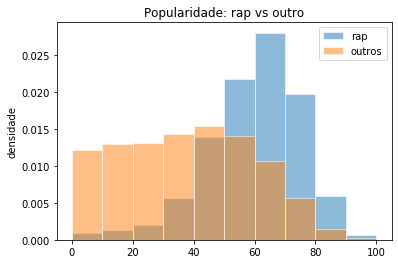

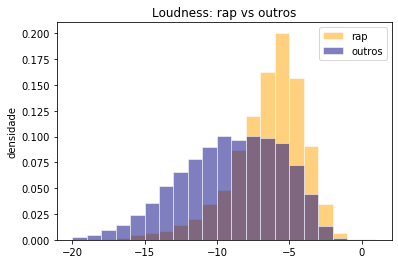

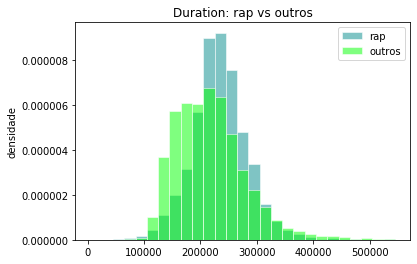

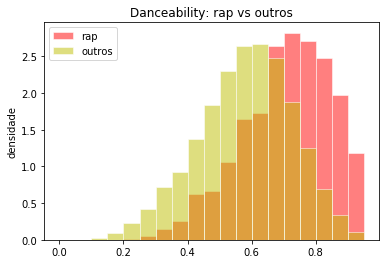

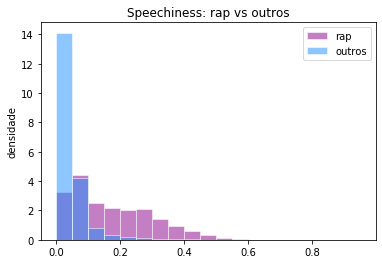

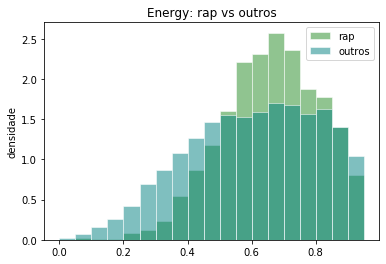

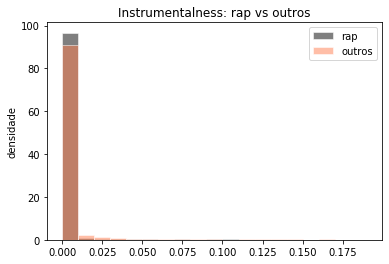

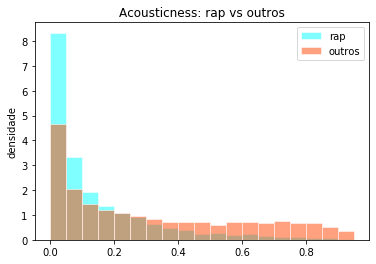

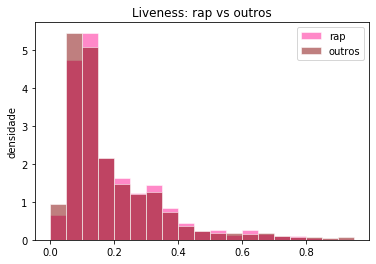

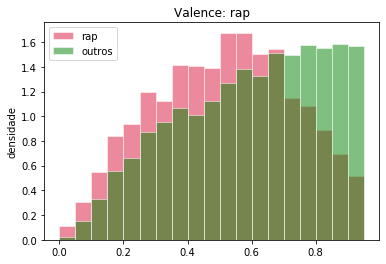

In [11]:
#histograma de rap e popularidade, e histograma de outros gêneros e popularidade.

popularidade = dados_rap.loc[:,'spotify_track_popularity']
popularidade_2 = dados_outro.loc[:,'spotify_track_popularity']

amplitude = np.arange(0,101,10)
plt.hist(popularidade, bins= amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Popularidade: rap vs outro')
plt.ylabel('densidade')
plt.hist(popularidade_2, bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#-----------------------------------------------------------

#histograma de rap e 'loudness', e histograma de outros gêneros e 'loudness'.

loud = dados_rap.loc[:,'loudness']
loud_2 = dados_outro.loc[:,'loudness']

amplitude = np.arange(-20,2,1)
plt.hist(loud, color='orange', bins=amplitude, label='rap',edgecolor='white',density=True,alpha=0.5)
plt.title('Loudness: rap vs outros')
plt.ylabel('densidade')
plt.hist(loud_2, color='navy', bins= amplitude, label='outros', edgecolor='white', density=True,alpha=0.5)
plt.legend()
plt.show()

#------------------------------------------------------------------

#histograma de rap e duração da música, e histograma de outros gêneros e 'duração da música'

duration = dados_rap.loc[:,'spotify_track_duration_ms']
duration_2 = dados_outro.loc[:,'spotify_track_duration_ms']
amplitude = np.arange(5000,550000,20000)
plt.hist(duration, color='darkcyan', bins= amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Duration: rap vs outros')
plt.ylabel('densidade')
plt.hist(duration_2, color='lime', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

# ------------------------------------------------------------------

#histograma de rap e 'dançabilidade', e histograma de outros gêneros e 'dançabilidade'

danceability = dados_rap.loc[:,'danceability']
danceability_2 = dados_outro.loc[:,'danceability']
amplitude = np.arange(0,1,0.05)
plt.hist(danceability, color='red', bins= amplitude, label = 'rap',edgecolor='white',density=True, alpha=0.5)
plt.title('Danceability: rap vs outros')
plt.ylabel('densidade')
plt.hist(danceability_2, color='y', bins= amplitude, label='outros',edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#-------------------------------------------------------------------------

#histograma de rap e 'speechiness', e histograma de outros gêneros e 'speechiness'

speechiness = dados_rap.loc[:,'speechiness']
speechiness_2 = dados_outro.loc[:,'speechiness']

amplitude = np.arange(0,1,0.05)
plt.hist(speechiness, color='darkmagenta', bins=amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Speechiness: rap vs outros')
plt.ylabel('densidade')
plt.hist(speechiness_2, color='dodgerblue', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#-----------------------------------------------------------------------------

#histograma de rap e energia, e histograma de outros gêneros e energia

energy = dados_rap.loc[:,'energy']
energy_2 = dados_outro.loc[:,'energy']

amplitude = np.arange(0,1,0.05)
plt.hist(energy, color='forestgreen', bins=amplitude,label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Energy: rap vs outros')
plt.ylabel('densidade')
plt.hist(energy_2, color='teal', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#--------------------------------------------------------------------------------------

#histograma de rap e instrumental, e histograma de outros gêneros e instrumental

instrumental = dados_rap.loc[:,'instrumentalness']
instrumental_2 = dados_outro.loc[:,'instrumentalness']

amplitude = np.arange(0,0.2,0.01)
plt.hist(instrumental, color='black', bins=amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Instrumentalness: rap vs outros')
plt.ylabel('densidade')
plt.hist(instrumental_2, color='coral', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#--------------------------------------------------------------------------------------------

#histograma de rap e acústico, e histograma de outros gêneros e acústico

acoustic = dados_rap.loc[:,'acousticness']
acoustic_2 = dados_outro.loc[:,'acousticness']

amplitude = np.arange(0,1,0.05)
plt.hist(acoustic, color='aqua', bins= amplitude,label = 'rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Acousticness: rap vs outros')
plt.ylabel('densidade')
plt.hist(acoustic_2, color='orangered', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#-----------------------------------------------------------------------------

#histograma de rap e 'liveness', e histograma de outros gêneros e 'liveness'

live = dados_rap.loc[:,'liveness']
live_2 = dados_outro.loc[:,'liveness']

amplitude = np.arange(0,1,0.05)
plt.hist(live, color='deeppink', bins = amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Liveness: rap vs outros')
plt.ylabel('densidade')
plt.hist(live_2, color='maroon', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()

#---------------------------------------------------------------------------

#histograma de rap e valence, e histograma de outros gêneros e valence

valence = dados_rap.loc[:,'valence']
valence_2 = dados_outro.loc[:,'valence']

amplitude = np.arange(0,1,0.05)
plt.hist(valence, color='crimson', bins=amplitude, label='rap', edgecolor='white',density=True, alpha=0.5)
plt.title('Valence: rap')
plt.ylabel('densidade')
plt.hist(valence_2, color='g', bins= amplitude, label='outros', edgecolor='white', density=True, alpha=0.5)
plt.legend()
plt.show()


Ao observar o primeiro gráfico plotado, percebe-se que a popularidade das músicas de rap tem uma densidade maior, ou seja, concentram-se mais em torno de 60 a 70 enquanto o gráfico dos outros gêneros tem maior densidade em torno dos 50 a 60, sendo essa densidade menor que a maior densidade do rap. De maneira geral, através do gráfico vê-se que o 'rap' tem popularidades maiores do que os outros gêneros, indicando um bom ponto que antes não havíamos notado e que poderá fazer grande diferença na classificação.

Além disso, em relação ao gráfico 'loudness', percebe-se que embora a diferença não pareça muito grande na tabela de medidas-resumo, o gênero 'rap' mais uma vez apresenta valores maiores em comparação a outros gêneros, principalmente porque os outros gêneros englobam maior variedade de músicas, desde clássicas até 'heavy metal', o que pode afetar em sua distribuição e densidade. 

Por sua vez, a duração de músicas de 'rap' tende a ser mais concentrada em torno dos 200000 a 250000mS, enquanto que para valores de duração maiores os outros gêneros predominam. Ademais, também interessante notar que para valores de duração menores, os outros gêneros predominam. 

Em relação ao tópico 'danceability', nota-se também que o gênero 'rap' está concentrado nos maiores valores, indicando que o tipo de música que engloba esse gênero tende a ser mais dançável do que os outros. O contrário também é real, os valores menos dançáveis pertencem aos outros gêneros e não ao 'rap. 

No gráfico de 'speechiness', a diferença observada é realmente significativa, já que os valores do gênero 'rap' tendem a ser muito mais próximos de 1.0 (o que indica maior presença de palavras faladas em uma música) do que os outros gêneros, que se concentram mais em torno de 0.0. Sendo assim, ao analisar esse gráfico percebe-se que 'speechiness' será uma característica muito importante para o nosso classificador.

Para o gráfico de energia, percebe-se que os valores do 'rap' tendem a ser mais homogêneos. De maneira geral, esse pode ser considerado um gênero mais energético, porém também pode-se notar que para valores mais altos, os outros gêneros apresentam maior densidade. 

Em relação ao instrumental, percebe-se que como esperado o 'rap' não é um gênero que é composto apenas de instrumentos, ou seja, a sua maioria contém vocais. Os outros gêneros também tendem a ser não instrumentais (lembrando que estamos trabalhando com músicas que fizeram parte do top 100 hot da Billboard durante os anos), porém como há maior variedade apresentam uma suave assimetria à direita, enquanto o gráfico do 'rap' é mais homogêneo.

Sobre a acústica das músicas, também notamos que o 'rap' não é um gênero que utiliza muito de instrumentos acústicos, utilizando mais ferramentas eletrônicas para a elaboração de suas faixas. Inclusive, percebe-se que para valores mais próximos de 1.0, os outros gêneros predominam, tendo maior densidade. 

Já no gráfico de 'liveness' , que mostra a presença ou não de um público, percebe-se que ambos: rap e outros gêneros, apresentam resultados bem parecidos, sendo esses muito baixos. O que é coerente, já que a plataforma 'Spotify' concentra mais albúns gravados em estudio do que ao vivo. 

Por fim, sobre a valência, que indica a positividade de uma música, percebe-se que o gráfico do 'rap' se comporta mais como uma distribuição normal, tendo uma média em torno de 0.5, assim, tanto para maiores valores quanto para menores valores, perceb-se pouca densidade no histograma. Em contrapartida, o gráfico de valência dos outros gêneros se assemelham mais a uma assimetria à esquerda, tendo uma grande densidade nos valores mais próximos de 1.0. 

Logo, por meio dessas observações, percebe-se que os gráficos mostram diferenças nos features quantitativos que a princípio não sabíamos que existiam.  

Depois de realizar a análise com as variáveis quantitativas, foi o momento de realizar a análise com os dois dados qualitativos de nossa base de dados: modo('Mode') e explicitabilidade ('spotify_track_explicit').

In [12]:
#realizando o crosstab para saber a relação entre classificação e 'Mode'.
pd.crosstab(DataFrame['classificacao'],DataFrame['mode'],normalize='index',margins=True).round(2)*100

mode,Minor,Major
classificacao,,
Outro,24.0,76.0
Rap,44.0,56.0
All,27.0,73.0


In [13]:
#realizando o crosstab para saber a relação entre classificação e explicitabilidade.
pd.crosstab(DataFrame['classificacao'],DataFrame['spotify_track_explicit'],normalize='index',margins=True).round(2)*100

spotify_track_explicit,Free,Explicit
classificacao,,
Outro,98.0,2.0
Rap,35.0,65.0
All,89.0,11.0


Como pode ser observado nas tabelas cruzadas acima, em relação ao modo, tanto o gênero 'rap' quanto os outros gêneros são escritos mais em escalas maiores. Porém, em relação a explicitabilidade, percebe-se que o gênero 'rap' é em sua maioria explícito, ou seja, contém letras com mais palavras de baixo calão, ao contrário dos outros gêneros. Isso já nos mostra que esse feature será muito importante para a classificação do nosso target final, podendo ter um papel de destaque em relação à outros. 

## 3 ) Aplicação da técnica: 'Random Forest'

Já nesse terceiro tópico, iremos implementar a técnica para classificação conhecida como 'Random Forest'. Random vem do inglês e  significa aleatório, denotando o comportamento do algoritmo ao selecionar subconjuntos de features e montar mini árvores de decisão. Forest significa floresta, já que são geradas várias árvores de decisão. Sendo assim, várias possibilidades são criadas para a melhor classificação da nossa base de teste.

### [3.1] Treinamento e Teste:

Agora, vamos separar o DataFrame já limpo em `Treinamento`, utilizado para treinar nosso classificador, e `Teste`, para analisar o funcionamento do classificador já criado e treinado, sendo 70% para o Treinamento e 30% para o Teste. Mas antes, precisávamos alterar algumas coisas para que nossos dados pudessem ser utilizados corretamente pela biblioteca do `scikit.learn`. Sendo assim, começamos modificando as variáveis qualitativas e as transformamos em `dummies`, para que a ausência ou a presença de algum efeito categórico que pode modificar resultados seja substituído apenas pelos valores de 0 ou 1. 

In [14]:
#Criamos dummies para as varíaveis qualitativas

Mode_Explicit = pd.get_dummies(DataFrame[['mode','spotify_track_explicit']])
DataFrame = DataFrame.join(Mode_Explicit)


In [15]:
# Modificamos as variáveis que classificação que antes eram 'Outros' e 'Rap' e que passaram a ser 0 e 1, respectivamente.

DataFrame['classificacao'].cat.categories = [0,1]
DataFrame['classificacao'] = DataFrame['classificacao'].astype('int64')



In [16]:
#================================================= Criando os DataFrames ======================================================
# para o X do Dataframe novo
Lista_Colunas = list(DataFrame.columns)
Lista_Colunas.remove('spotify_genre')
Lista_Colunas.remove('classificacao')
Lista_Colunas.remove('mode')
Lista_Colunas.remove('spotify_track_explicit')
X = DataFrame[Lista_Colunas]

# para o y do Dataframe novo
y = DataFrame['classificacao']

# aplicando a função: Treinamento com 70% do DataSet:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
#Realizando o treinamento do classificador.

clf_random = RandomForestClassifier(max_depth=2, random_state=0)
clf_random.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [18]:
#Testando a eficácia da base de teste com o classificador já treinado.

clf_random.score(X_test, y_test)

0.9383309759547384

Como visto acima, o nosso classificador teve uma acurácia de cerca de 92%, demonstrando a príncipio um bom resultado em julgar uma música sendo 'rap' ou não apenas através de suas características musicais descritas no trabalho. Porém, afim de saber mais a fundo sobre esse resultado, plotamos a matriz de confusão, que é uma matriz de dimensão 2 x 2, capaz de calcular a quantidade de falso positivo e falso negativo, e de verdadeiro positivo e verdadeiro negativo, além de que por meio dela é possível saber a acurácia e a sensibilidade. Sendo assim, fizemos o que se encontra abaixo: 

In [19]:
#plotando a matriz de confusão

y_true = y_test
y_pred = clf_random.predict(X_test)
matriz_random = confusion_matrix(y_true, y_pred)
matriz_random

array([[5958,  118],
       [ 318,  676]], dtype=int64)

Na matriz plotada, tem-se que a diagonal principal é composta de cima para baixo, respectivamente, dos valores de verdadeiro positivo (5958) e verdadeiro negativo (676). Por sua vez, os valores da diagonal secundária são compostos de cima para baixo, respectivamente, pelos valores de falso positivo (118) e falso negativo (318).

Agora, como exemplo do que foi feito pelo classificador, selecionamos uma árvore de decisão e criamos um documento `.dot` que quando convertido em imagem representa uma das árvores feitas pelo classificador.

In [20]:
classificacao = ['outro','rap']

# Extraindo uma árvore de decisão
estimator = clf_random.estimators_[5]

from sklearn.tree import export_graphviz
# Exportando o documento .dot 
export_graphviz(estimator, out_file='classificacao.dot', 
                feature_names = X_train.columns,
                class_names = classificacao,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

#Gerou o documento 'classificacao.dot' 

Após criar esse documento, realizamos a conversão no site: https://dreampuf.github.io/GraphvizOnline/ e geramos a seguinte imagem: 

   <img src="Decision_tree_random.png" width="486">

Como se vê, o exemplo dessa árvore mostra inclusive uma das variáveis mais importantes para a classificação e que mostraram as maiores diferenças entre 'rap' e outros gêneros, que são a variável de explicitabilidade e a variável 'speechiness'.

## 4 ) Aplicação da técnica: '' Regressão Logística"

Após implementar a técnica para classificação conhecida como 'Random Forest', vamos agora aplicar uma outra chamada de 'regressão logística', que é uma técnica capaz de estimar a probabilidade relacionada à ocorrência de um evento, tendo um conjunto de variáveis explanatórias. E, os resultados dessa análise ficam em um intervalo de 0 a 1.   

### [4.1] Treinamento do classificador e resultado:

Já que as modificações necessárias para o DataFrame já foram feitas para a classificação acima, começamos treinando nosso classificador e para isso fizemos uso da biblioteca: 'LogisticRegression' do `scikit.learn`. Após treinar nosso classificador, pedimos para que aplicasse a técnica no DataFrame de teste para verificar sua acurácia. 

In [21]:
#Treinando nosso classificador com a técnica de regressão logística. 

clf_log = LogisticRegression(random_state=0).fit(X_train, y_train)
clf_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
#Aplicando essa técnica no DataFrame para verificar sua performance. 

clf_log.score(X_test, y_test)

0.8561527581329561

Após ter o resultado da acurácia do modelo de regressão logística, também é necessário verificar a fundo como de fato foi feita essa classificação, e isso pode ser feito mais uma vez pela matriz de confusão, que se encontra abaixo:

In [23]:
# plotando matriz de confusão.

y_true = y_test
y_pred = clf_log.predict(X_test)
matriz_log = confusion_matrix(y_true, y_pred)
matriz_log

array([[5980,   96],
       [ 921,   73]], dtype=int64)

Como observado, o número de verdadeiros positivos é de 5980, e o número de verdadeiros negativos é 73. Enquanto que o número de falsos positivos é 96 e o número de falsos negativos é 921.

## 5 ) Aplicação da técnica: '' Árvore de decisão"

Agora iremos aplicar uma outra técnica um tanto quanto parecida com a técnica do 'Random Forest', que é a 'Decision Tree' ('árvores de decisão'). A diferença entre a 'Random Forest' e a 'Árvore de decisão', é que a primeira técnica citada não utiliza uma, mas sim várias árvores de decisão. E o que é uma árvore de decisão? Podemos dizer que ela é um mapa dos possíveis resultados de várias escolhas associadas. Uma árvore de decisão geralmente começa com um nó, que vai se ramificando, ou seja, que vai gerando vários resultados e probabilidades e que no fim conduzem a uma possível decisão a ser tomada. 

### [5.1] Treinamento do classificador e resultado:

Do mesmo modo que foi feito acima, começamos treinando nosso classificador e para isso fizemos uso mais uma vez de uma biblioteca do `scikit.learn`, a 'tree'. Após treinar nosso classificador, pedimos para que aplicasse a técnica no DataFrame de teste para verificar por fim a sua eficácia. 

In [24]:
#Treinando nosso classificador com a técnica de árvore de decisão. 

X = X_train
Y = y_train
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X, Y)
clf_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
#Aplicando essa técnica no DataFrame para verificar sua performance. 

clf_tree.score(X_test,y_test)

0.9035360678925035

In [26]:
# plotando a matriz de confusao

y_true = y_test
y_pred = clf_tree.predict(X_test)
matriz_tree = confusion_matrix(y_true, y_pred)
matriz_tree

array([[5720,  356],
       [ 326,  668]], dtype=int64)

Mais uma vez, depois de verificar o 'score' do modelo, plotamos também a matriz de confusão. Essa apresentou um resultado de 5717 verdadeiros positivos, 667 verdadeiros negativos, 359 falsos positivos e 327 falsos negativos.

## 6 ) Análise dos resultados

Agora, vamos analisar mais a fundo os resultados obtidos anteriormente nas três técnicas diferentes que foram executadas. 


### [6.1] Descrição das medidas de análise:


Para avaliar o desempenho de nossos classificadores, utilizamos acima a função `.score()` do `scikit.learn` que serve para sabermos se o nosso modelo conseguirá realizar a classificação com dados que ele nunca viu, tendo sido treinado com outros dados. Para executar essa função tivemos que primeiro treinar nosso classificador com os dados de treinamento, só depois executar a função que verifica o número que o modelo previu com o valor esperado dos dados de teste. Como resultado, temos um número entre 0.0 e 1.0, sendo que quanto mais próximo o número for de 1.0 melhor.    

Porém, não se deve realizar a análise dos resultados apenas através da função `.score()`, pois embora ela mostre a acurácia do modelo, há também outras medidas muito importantes e de igual significância que devem ser levadas em consideração. Foi para isso, que para cada técnica de classificação aplicada, plotamos também a matriz de confusão. Essa, como dito acima, fornece a quantidade de falsos positivos e falsos negativos, bem como a quantidade de verdadeiros positivos e verdadeiros negativos. Além disso, por meio dela é possível calcular essas outras importantes medidas que são a sensibilidade e a especificidade do modelo.

A distribuição dos verdadeiros positivos, negativos e falsos positivos e negativos, encontra-se na figura abaixo:

   <img src="tabela_excel.jpg" width="486">

A 'sensibilidade' representa a proporcionalidade de verdadeiros positivos, e para calculá-la basta dividir o número da primeira linha e da primeira coluna da matriz pelo total dos casos que seriam positivos (a soma da primeira linha e primeira coluna com a segunda linha e primeira coluna da matriz).

Já a 'especificidade' expressa a proporção de casos negativos identificados corretamente. O cálculo dessa medida é feito através da divisão dos verdadeiros negativos pelo seu total (a soma da primeira linha e segunda coluna com a segunda linha e segunda coluna). 

Por fim, a 'acurácia', já calculada pelo `.score()`, representa a proporção de casos que foram previstos corretamente, isto é, a soma de verdadeiros positivos e verdadeiros negativos divididos pelo total. 



### [6.2] Análise do primeiro modelo: 'Random Forest'

 

A primeira técnica implementada em nossa base de testes foi a 'Random Forest', e essa técnica obteve uma acurácia de `0.9383309759547384`, o que a príncipio é muito boa, sendo inclusive a maior acurácia obtida dentre as técnicas aplicadas. Porém, como visto anteriormente, a análise de uma técnica não para apenas na acurácia, e por isso, foram calculadas a sensibilidade e a especificidade do modelo. Os valores obtidos encontram-se abaixo: 


In [27]:
# cálculo da sensibilidade e especificidade da 'Random Forest'

sensibilidade_random = matriz_random[0,0]/ (matriz_random[0,0] + matriz_random[1,0])
especificidade_random = matriz_random[1,1]/ (matriz_random[0,1] + matriz_random[1,1])

print('A sensibilidade da técnica Random Forest é de: {0}'.format(sensibilidade_random))
print('A especificidade da técnica Random Forest é de: {0}'.format(especificidade_random))

A sensibilidade da técnica Random Forest é de: 0.9493307839388145
A especificidade da técnica Random Forest é de: 0.8513853904282116


Como visto nos resultados calculados, além de uma boa acurácia, esta técnica demostrou também uma boa sensibilidade e uma boa especificidade, já que seus valores obtidos foram bem próximos de 1.0, ou seja, o programa identificou muito bem os casos em que a música pertencia ao gênero rap e os casos que pertencia aos outros gêneros.  

### [6.2] Análise do segundo modelo: 'Regressão Logística'

Já a segunda técnica aplicada foi a de regressão logística, que obteve uma acurácia de `0.8561527581329561`, que por sua vez foi a menor acurácia dentre as técnicas utilizadas, embora não deixe de ser uma valor consideravelmente razoável. Agora, vamos analisar sua sensibilidade e especificidade:  
 

In [28]:
# cálculo da sensibilidade e especificidade da 'Regressão Logística'

sensibilidade_log = matriz_log[0,0]/ (matriz_log[0,0] + matriz_log[1,0])
especificidade_log = matriz_log[1,1]/ (matriz_log[0,1] + matriz_log[1,1])

print('A sensibilidade da técnica de Regressão Logística é de: {0}'.format(sensibilidade_log))
print('A especificidade da técnica de Regressão Logística é de: {0}'.format(especificidade_log))

A sensibilidade da técnica de Regressão Logística é de: 0.8665410810027532
A especificidade da técnica de Regressão Logística é de: 0.4319526627218935


Comparando os resultados obtidos nesse modelo com o anterior, precebe-se uma grande diferença na especificidade que apresentou um desempenho ruim, sendo mais próximo de 0.0 do que de 1.0, ou seja, embora o programa tenha identificado bem os casos em que a música era 'rap', não conseguiu identificar bem os casos em que a música pertencia à outros gêneros. Portanto, ainda que tenha tido uma acurácia boa, esse modelo apresenta falhas que podem comprometer bastante a análise de outros possíveis bancos de dados relacionados.

### [6.3] Análise do terceiro modelo: 'Árvore de decisão'

Por fim, a última técnica implementada foi a de árvore de decisão, que por sua vez obteve uma acurácia de `0.902970297029703`, ficando essa no meio dentre as outras acurácias obtidas. Em termos de sensibilidade e especificidade, estes foram os valores calculados: 

In [29]:
# cálculo da sensibilidade e especificidade da 'Árvore de Decisão'

sensibilidade_tree = matriz_tree[0,0]/ (matriz_tree[0,0] + matriz_tree[1,0])
especificidade_tree = matriz_tree[1,1]/ (matriz_tree[0,1] + matriz_tree[1,1])

print('A sensibilidade da técnica de Árvore de Decisão é de: {0}'.format(sensibilidade_tree))
print('A especificidade da técnica de Árvore de Decisão é de: {0}'.format(especificidade_tree))

A sensibilidade da técnica de Árvore de Decisão é de: 0.9460800529275554
A especificidade da técnica de Árvore de Decisão é de: 0.65234375


Em relação aos resultados obtidos, percebe-se que o valor de sensibilidade desse modelo foi muito próximo da sensibilidade obtida no 'Random Forest', com uma diferença mínima, sendo a sensibilidade do 'Random Forest' um pouco melhor, o que indica que ambos classificaram muito bem quando as músicas pertenciam ao gênero 'rap'. Porém, ao analisar sua especificidade, percebe-se que o resultado obtido foi próximo da média, o que mostra que o classificador não conseguiu analisar bem as músicas que pertenciam à outros gêneros.  

### [6.4] Todos os resultados

Com todos os dados de especificidade, sensibilidade e acurácia montamos uma tabela para demonstração dos três modelos. Encontra-se abaixo:

   <img src="tabela_matriz_confusao.png" width="486">


## 7 ) Conclusão : a técnica de melhor desempenho

Para o nosso objetivo, que era conseguir classificar corretamente as músicas que pertenciam ao gênero 'rap', de modo a realizar uma boa distinção dos outros gêneros, nota-se que a técnica que apresentou melhor acurácia, melhor sensibilidade e melhor especificidade foi a técnica 'Random Forest'. 

Essa técnica inclusive é amplamente utilizada, pois pode realizar classificações tanto para regressão quanto para classificação. Além disso, o algoritmo desse modelo adiciona uma aleatoriedade extra quando está criando as árvores. Assim, ao invés de procurar pela melhor característica quando está dividindo os nós, como ocorre nas árvores de decisão, ele busca a característica de maior significância em um subconjunto aleatório, o que por sua vez resulta em maior diversidade e gera modelos mais precisos.  Isso explica o porquê no caso analisado, a técnica 'Random Forest' apresentou maior desempenho. Com os 10 features que compuseram nosso treinador, a maior variabilidade trouxe consigo maior precisão para classificar de acordo com o nosso target. Assim, como no ditado popular, juntas, as florestas de árvores aleatórias são mais fortes. 

Além disso, a 'Random Forest' é uma técnica não tão afetada por dados discrepantes e apresenta um algoritmo estável, o que faz com que introduzir um novo dado não afete muito os resultados, uma vantagem em relação às 'Ávores de decisão', já que embora demandem menor esforço no preparo dos dados no período de pré-processamento e seja um modelo mais fácil para explicar, a modificação de poucas coisas nos dados pode acarretar mudanças nas estruturas que pode comprometer a análise. 

Em relação a técnica de regressão logística, pode-se afirmar que essa técnica não assume nenhuma distribuição ou importância de classes, além de ser muito boa para 'DataSets' simples quando os dados são linearmente separáveis, o que não foi o caso do DataSet do trabalho. Além disso, esse modelo em geral tem maior facilidade de lidar com variáveis categóricas, o que pode ter atrapalhado um pouco o treinamento do classificador, já que apenas dois de nossos features eram categóricas, enquanto a maioria eram features numéricas. 


Portanto, conclui-se que para o nosso caso em específico, o melhor modelo foi o 'Random Forest'. Já que com as dez features, conseguiu atribuir importâncias àqueles que tinham grande diferença em relação á outros gêneros musicais e que com as várias 'florestas de probabilidades' geradas conseguiu selecionar as melhores.

## 8 ) Referências

VASCONCELLOS, Paulo. 'Como saber se seu modelo de Machine Learning está funcionando mesmo'. Disponível em : <https://paulovasconcellos.com.br/como-saber-se-seu-modelo-de-machine-learning-est%C3%A1-funcionando-mesmo-a5892f6468b>. Acesso em 24/11/2020;

MARCIANO, Carlos Eduardo e DAVIM, João Victor. 'Modelos Preditivos de Notas de Redação do ENEM 2015'. Disponível em : <https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015/>. Acesso em 24/10/2020;

KUMAR, Naresh. 'Advantages and Disadvantages of Random Forest Algorithm in Machine Learning'. Disponível em: <https://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of-random.html>. Acesso em 24/10/2020;

ROUT, Amiya Ranjan. 'Advantages and Disadvantages of Logistic Regression'. Disponível em: <https://www.geeksforgeeks.org/advantages-and-disadvantages-of-logistic-regression/#:~:text=Logistic%20regression%20is%20easier%20to,of%20classes%20in%20feature%20space>. Acesso em 24/10/2020;

SPOTIFY. 'Get Audio Features for a Track'. Disponível em : <https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/>. Acesso em 24/10/2020.

